# ISYE/Math/CS 425 - Assignment 6
### Members
- Bryan Luu
- Mehmet Ali Tever

All code in Julia 1.5.2

## Contents
- [Exercise 1](#Exercise-1)
- [Exercise 2](#Exercise-2)
- [Exercise 3](#Exercise-3)
- [Exercise 4](#Exercise-4)
- [Exercise 5](#Exercise-5)

## Helper Functions

Import libraries used

In [1]:
using LightGraphs, MetaGraphs, LightGraphsMatching, GraphRecipes, Plots

In [2]:
connect(P) = [Edge(u, v) for (u, v) in zip(P[1:end-1], P[2:end])];
middle(a) = a[ceil(Int, length(a)/2)];
incident(v::Int, e::T) where {T <: AbstractEdge} = e.src == v || e.dst == v;
sum_str(x) = join(x, " + ") * " = $(sum(x))";
wts(E, wd) = [wd[(e.src, e.dst)] for e in E];

function disconnect(E)
    path = []
    s = nothing;
    for e in E
        s, d = e.src, e.dst;
        push!(path, s);
        s = d;
    end
    push!(path, s);
    return path
end

function unique(E::Array{T, 1}; directed=false) where {T <: AbstractEdge}
    tmp = copy(E);
    new = T[];
    while !isempty(tmp)
        e = pop!(tmp);
        removed = remove!(e, tmp; symmetric=!directed);
        push!(new, e);
    end
    return new;
end

function normalize(x::Array{T, 1}) where {T <: Real}
    mx, Mx = min(x...), max(x...); # limits
    return Mx == mx ? x.*0 : (x.-mx)./(Mx .- mx)
end

function place!(mg, v, position)
    set_prop!(mg, v, :position, position);
end

function connect!(mg, wd, u, v, weight)
    add_edge!(mg, u, v);
    set_prop!(mg, u, v, :weight, weight);
    wd[(u, v)] = wd[(v, u)] = weight;
end

function remove(e, E; symmetric=true, 
        condition=(k)->(k == e || (symmetric && k == reverse(e))))
    return [k for k in E if !condition(k)];
end

function remove!(e, E; symmetric=true, 
        condition=(k)->(k == e || (symmetric && k == reverse(e))))
    i = 1;
    removed = []
    while i <= length(E)
        if condition(E[i])
            push!(removed, popat!(E, i));
            continue;
        end
        i += 1;
    end
    return removed;
end

function emphasize(E::Array{T, 1}; directed=false) where {T <: AbstractEdge}
    function ew(s, d, w)
        e = Edge(s, d);
        re = reverse(e);
        if in(e, E) || (!directed && in(re, E))
            return 3;
        else
            return 1;
        end
    end
    return ew;
end;

function plot_fixed(g::MetaGraph; names=vertices(g), positions=[], ew=(s, d, w)->1, args...)
    N = nv(g);

    mg = copy(g); # create internal connected copy
    fake = Dict();
    if !is_connected(mg)
        for v in 2:N
            if is_connected(mg)
                break
            end
            add_edge!(mg, 1, v);
            fake[1, v] = true;
        end
    end

    new_ew(s, d, w) = get(fake, (s, d), false) ? 0 : ew(s, d, w);

    if isempty(positions)
        positions = [get_prop(g, v, :position) for v in 1:N];
    end
    
    x = [pos[1] for pos in positions];
    y = [pos[2] for pos in positions]; # Flip the y so that (0,0) is bottom-left.
    
    graphplot(mg; x=normalize(x), y=normalize(y), names=names, ew=new_ew, args...);
end;

## Exercise 1

![Missing!](q1.jpg)

## Exercise 2

![Missing!](q2.jpg)

## Exercise 3

Weights:
1 <-> 2: 2
2 <-> 3: a
1 <-> 4: 2
2 <-> 4: b
1 <-> 3: 1
3 <-> 4: a


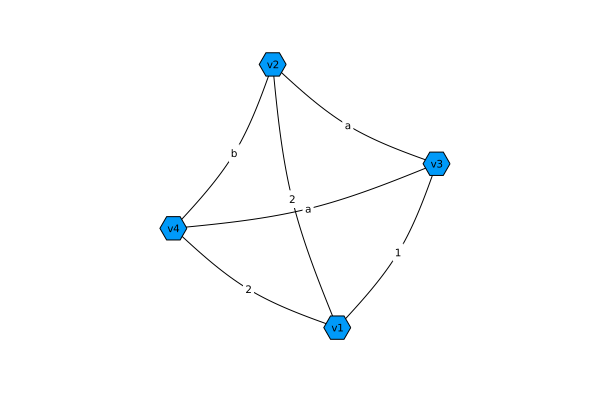

In [3]:
g = complete_graph(4);
mg = MetaGraph(g);

wd = Dict();
wd[(1, 2)] = 2;
wd[(1, 3)] = 1;
wd[(1, 4)] = 2;
wd[(2, 3)] = :a;
wd[(2, 4)] = :b;
wd[(3, 4)] = :a;

println("Weights:");
for e in keys(wd)
    u, v = e;
    set_prop!(mg, e..., :weight, wd[e]);
    println(join(e, " <-> ") * ": $(wd[e])");
end


graphplot(mg, names=["v$(i)" for i in 1:4], el=wd)

Let $c(P)$ be the cost of a given path $P$ of graph $G$.

Consider the above graph $G$, which is a connected graph of size $|V| = 4$. Since $c$ can be arbitrary, it can be used to 'force' the NN path to take an initial cheap edge but end on an expensive edge. For this graph to break the triangle inequality, we have the following conditions:

$b > 2a$ OR $a > 3$ OR $b > 4$

If we define $a = 1 + \epsilon > 1$, and we start then the Nearest-Neighbor (NN) algorithm at $v_3$, the path obtained is: $P_{NN} = v_3\rightarrow v_1\rightarrow v_2\rightarrow v_3$ which has a cost of: 

$c(P_{NN}) = 1 + 2 + b + a = a + b + 3$. 

I.e. the NN-cost depends on $a$ and $b$. 
However, the general optimal path may not include $b$, for example the path $P^* = v3\rightarrow v_2\rightarrow v_1\rightarrow v_4\rightarrow v_3$ avoids $b$. This path has optimal cost 

$c(P^*) = a + 2 + 2 + a = 2a + 2$.

Then the ratio of the cost given by the NN tour and the optimal tour is:

$\frac{c(P_{NN})}{c(P^*)} = \frac{a+b+3}{2a+2}$

Say the first violation of triangle inequality holds (i.e. $b > 2a$), then:

$\frac{c(P_{NN})}{c(P^*)} = \frac{a+b+3}{2a+2} > \frac{3a + 3}{2a + 2} = 1.5 > 1$ so $c(P_{NN}) > c(P^*)$.

In other words, if the triangle inequality is not followed for this graph, it can lead to arbitrarily expensive NN tours.

## Exercise 4

To show that the bound in Theorem 7.1 cannot be decreased, we will show an example of this bound being met to prove this bound is tight.

We construct a complete graph $G$, with $n$ nodes $v_i$ for $i \in {1, 2, \dots, n}$, and edge costs $c_{v_i, v_j} = \lfloor (|j-i| + 1 / 2) \rfloor$ as suggested. From now on, we will call the cost between $v_i, v_j$ as simply $c_{ij}$. We make the following observations:
- every edge follows the triangle inequality
- every pair of nodes where the indices $i$, $j$ differ by at most 2 is connected by an edge costing 1.
- the largest cost edge is between $v_1$ and $v_n$, with cost $c_{v_1, v_n} = \lfloor n/2 \rfloor$.

From this observation, we can build an optimal tour $P^*$ as follows: 
1. Start at $v_1$.
2. Move up to the next odd index. This should be two indices above the current node. Repeat until the maximum odd index is reached.
3. Move to the highest even index nodex. This should be 1 index away.
4. Move down to the next even. This should be two indices below the current node. Repeat until the lowest maximum even index is reached.
5. Move to $v_1$ and complete the tour.

Because each step in $P^*$ differs by 2 indices at most, every edge has cost 1. There are $n$ edges in a tour. Thus, the optimal tour cost is $c(P^*) = n$.

Christofide's algorithm uses any MST as an input. We will choose a 'bad' tree and show that Christofide's algorithm will give us desired ratio over the optimal tour:
- The tree consisting of the path from $v_1$ to $v_n$ is an MST with costs of edge 1. This path has $n-1$ edges, so the cost of $T$ is $n-1$. 
- Next, the odd node set $W$ consists of just the endpoints: $W = \{v_1, v_n\}$
- Because of this, the induced subgraph $G[W]$ consists of the single edge between $v_1$ and $v_n$ with the largest cost $\lfloor n/2 \rfloor$.
- Therefore, the minimum-weight perfect matching is that single edge, and adding it to $T$ just adds the edge to the path from earlier. This creates the tour $P$ which is the output of Christofide's algorithm.
- The total cost of this tour is $c(P) = n - 1 + \lfloor n/2 \rfloor$.

The ratio of the Christofide's tour to the optimal tour is then:

$\frac{c(P)}{c(P^*)} = \frac{n - 1 + \lfloor n/2 \rfloor}{n} \approx \frac{3n/2 - 1}{n} = \frac{3}{2}$

So the bound is met and we are done.

Weights:
v1 <-> v2: 1
v1 <-> v3: 1
v1 <-> v4: 2
v2 <-> v3: 1
v2 <-> v4: 1
v3 <-> v4: 1


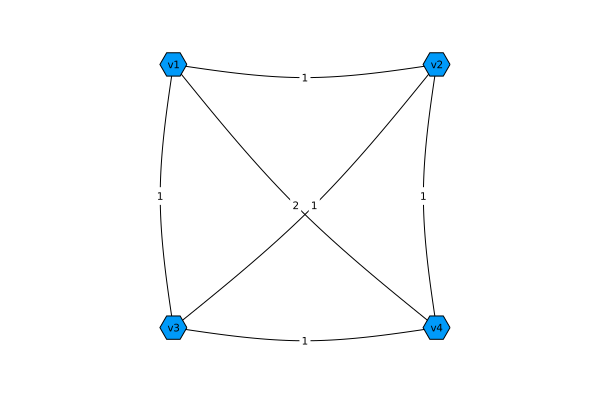

In [4]:
n = 4;
mg = MetaGraph(complete_graph(n));
wd = Dict();
println("Weights:")
for e in edges(mg)
    i, j = e.src, e.dst;
    wt = floor(Int, (abs(i - j) + 1)/2);
    set_prop!(mg, e, :weight, wt);
    wd[(e.src, e.dst)] = wd[(e.dst, e.src)] = wt;
    println("v$(i) <-> v$(j): $(wt)");
end

place!(mg, 1, (0, 0));
place!(mg, 2, (1, 0));
place!(mg, 3, (0, -1));
place!(mg, 4, (1, -1));

V = vertices(mg);
Vnames = [Symbol("v$(i)") for i in vertices(mg)];

plot_fixed(mg, names=Vnames, el=wd, curvature=0.05)

P*: v1 <-> v3 <-> v4 <-> v2 <-> v1
c(P*) = 1 + 1 + 1 + 1 = 4


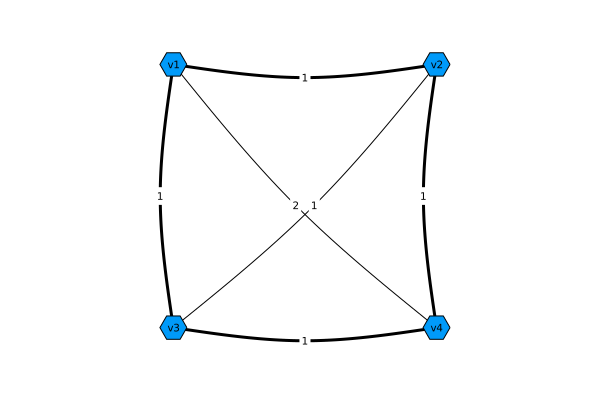

In [5]:
P_star = [V..., reverse(V)...][1:2:end];
push!(P_star, first(V));

E_star = connect(P_star);

println("P*: " * join(["v$(v)" for v in P_star], " <-> "))
println("c(P*) = " * sum_str(ones(Int, n)))

plot_fixed(mg, names=Vnames, el=wd, ew=emphasize(E_star), curvature=0.05)

MST T of G, rooted at v2: v1 <-> v2 <-> v3 <-> v4
c(T) = 1 + 1 + 1 = 3


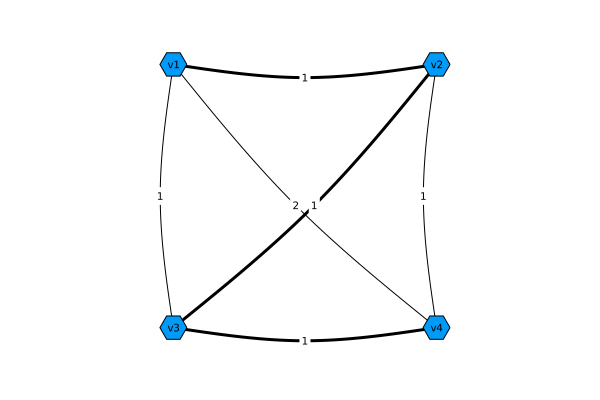

In [6]:
mst = [connect(1:middle(V)-1)...; Edge(middle(V) - 1, middle(V)); connect(middle(V):n)...;]

println("MST T of G, rooted at v$(middle(V)): " * join(["v$(v)" for v in 1:n], " <-> "));
println("c(T) = " * sum_str(ones(Int, n-1)))

plot_fixed(mg, names=Vnames, el=wd, ew=emphasize(mst), curvature=0.05)

Odd nodes W of T: v1, v4
M: v1 <-> v4
P: union(T, M) = v1 <-> v2 <-> v3 <-> v4 <-> v1
Christofide's cost: c(P) = 1 + 1 + 1 + 2 = 5


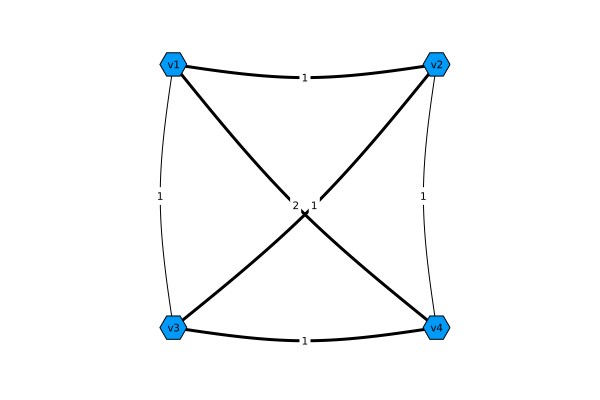

In [7]:
E_ = [mst..., Edge(n, 1)];
println("Odd nodes W of T: v1, v$(n)");
println("M: v1 <-> v$(n)");
println("P: union(T, M) = " * join(["v$(v)" for v in disconnect(E_)], " <-> "))
println("Christofide's cost: c(P) = " * sum_str(wts(E_, wd)))

plot_fixed(mg, names=Vnames, el=wd, ew=emphasize(E_), curvature=0.05)

## Exercise 5

In [19]:
mg = MetaGraph(SimpleGraph(8));

wd = Dict();

positions = Dict();
positions[1] = (0,0); positions[2] = (3,0); positions[3] = (5,0);
positions[4] = (2,1); positions[5] = (4,1);
positions[6] = (-0.5,2); positions[7] = (2,2.5); positions[8] = (5,2);
for (v, pos) in positions
    x, y = pos;
    place!(mg, v, (x, -y));
end

connect!(mg, wd, 1, 2, 11);
connect!(mg, wd, 2, 3, 11);
connect!(mg, wd, 1, 4, 4);
connect!(mg, wd, 1, 6, 7);
connect!(mg, wd, 2, 4, 7);
connect!(mg, wd, 2, 5, 6);
connect!(mg, wd, 3, 5, 5);
connect!(mg, wd, 3, 8, 6);
connect!(mg, wd, 4, 5, 1);
connect!(mg, wd, 4, 6, 3);
connect!(mg, wd, 4, 7, 9);
connect!(mg, wd, 5, 8, 2);
connect!(mg, wd, 6, 7, 7);
connect!(mg, wd, 7, 8, 11);

g = SimpleGraph(mg);

Given graph G:


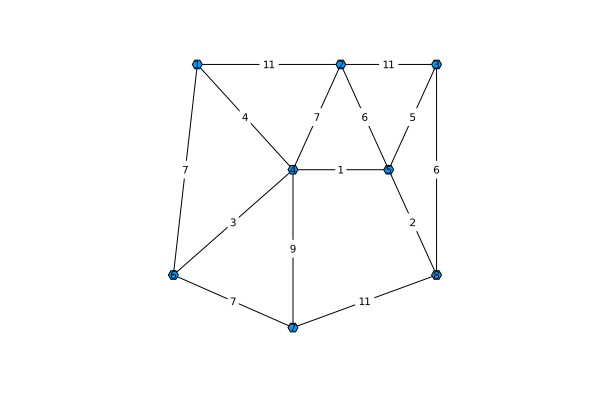

In [20]:
println("Given graph G:")
plot_fixed(mg, el=wd, curvature=0)

MST T of G shown in bold...
c(T): 1 + 2 + 3 + 4 + 5 + 6 + 7 = 28


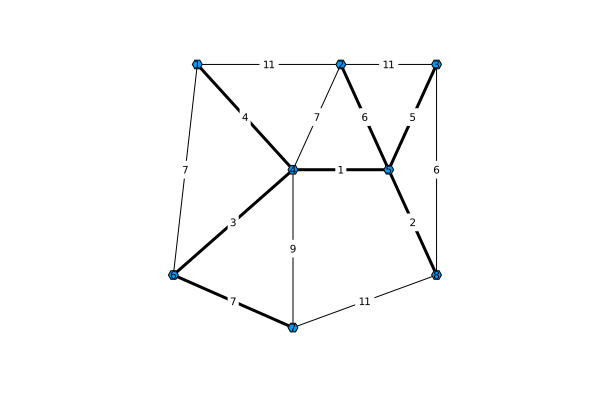

In [21]:
mst_edges = kruskal_mst(mg); # get MST
T, Tmap = induced_subgraph(g, mst_edges);
println("MST T of G shown in bold...")
println("c(T): " * sum_str(wts(mst_edges, wd)));
plot_fixed(mg, el=wd, ew=emphasize(mst_edges), curvature=0)

deg(4) = 3
deg(5) = 4
deg(8) = 1
deg(6) = 2
deg(1) = 1
deg(3) = 1
deg(2) = 1
deg(7) = 1
W (odd-degree nodes in T): 4, 8, 1, 3, 2, 7


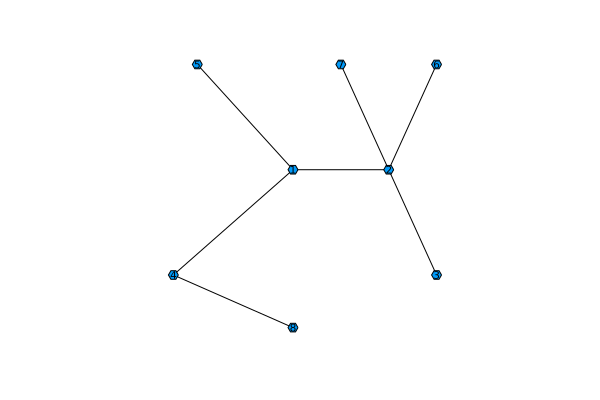

In [11]:
W = Int[];
for v in vertices(T)
    deg = degree(T, v);
    println("deg($(Tmap[v])) = $(deg)")
    if deg % 2 == 1
        push!(W, Tmap[v])
    end
end
println("W (odd-degree nodes in T): " * join(W, ", "))
plot_fixed(MetaGraph(T), 
    positions=[(positions[Tmap[i]][1], -positions[Tmap[i]][2]) for i in vertices(T)], curvature=0)

Matching M:
7 <-> 4
2 <-> 1
3 <-> 8
c(M): 9 + 11 + 6 = 26


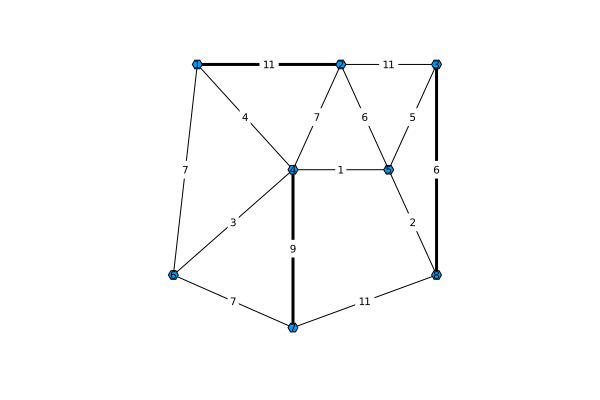

In [12]:
sg, Wmap = induced_subgraph(g, W);
wm = weights(sg); # matrix of weights
wd2 = Dict(e => wm[e.src, e.dst] for e in edges(sg)); # dictionary of weights
match = minimum_weight_perfect_matching(sg, wd2);
M = unique([Edge(Wmap[v], Wmap[match.mate[v]]) for v in vertices(sg)]);
println("Matching M:\n" * join(["$(e.src) <-> $(e.dst)" for e in M], "\n"))
println("c(M): " * sum_str(wts(M, wd)))
plot_fixed(mg, ew=emphasize(M), el=wd, curvature=0)

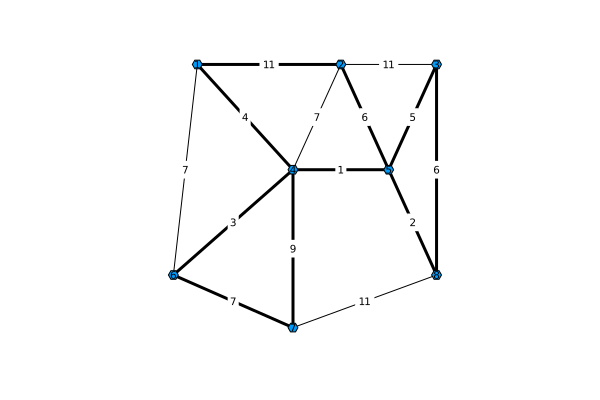

In [15]:
C = unique([mst_edges..., M...]); # Euler circuit with M + mst
cg, Cmap = induced_subgraph(g, C);
plot_fixed(mg, ew=emphasize(C), el=wd, curvature=0)

Tour: 
1 <-> 2 <-> 3 <-> 8 <-> 5 <-> 4 <-> 7 <-> 6 <-> 1
Cost of Christofide's Tour: 11 + 11 + 6 + 2 + 1 + 9 + 7 + 7 = 54


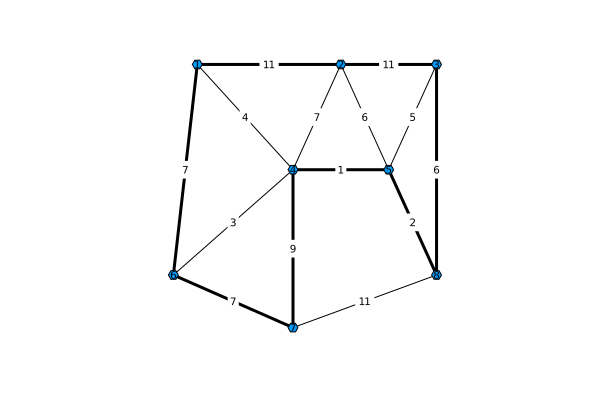

In [18]:
tour = C[:];
remove!(Edge(2, 5), tour);
remove!(Edge(3, 5), tour);
push!(tour, Edge(2, 3));

remove!(Edge(1, 4), tour);
remove!(Edge(4, 6), tour);
push!(tour, Edge(1, 6));

println("Tour: ")
nodes = tour[:];
path = [1];
while !isempty(nodes)
    curr = last(path);
    next = remove!(curr, nodes; condition=(e)->incident(curr, e));
    if isempty(next)
        push!(path, 1)
        break;
    end
    edge = next[1];
    curr = (edge.src == curr ? edge.dst : edge.src)
    push!(path, curr)
end
push!(path, 1)
println(join(path, " <-> "))

tour = connect(path);

println("Cost of Christofide's Tour: " * sum_str(wts(tour, wd)))

plot_fixed(mg, ew=emphasize(tour), el=wd, curvature=0)

## Exercise 6

![Missing!](q6.jpg)